In [1]:
import numpy as np
import pandas as pd
import os
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import hsv_to_rgb

import qtl.annotation
import qtl.plot
import qtl.torus
import style

annot = qtl.annotation.Annotation('data/gencode.v26.GRCh38.genes.gtf', verbose=False)
sample_df = pd.read_csv('data/GTEx_Analysis_v8_RNAseq_samples.txt', sep='\t')
sample_s = sample_df[sample_df['has_genotype']].groupby('tissue_id').apply(lambda x: x['sample_id'].tolist())
sample_s = sample_s[sample_s.apply(len)>=70]
size_s = sample_s.apply(len)

In [2]:
# VEP annotation for top eQTL/sQTL
vep_df = pd.read_csv('data/WGS_Feature_overlap_collapsed_VEP_short_4torus.MAF01.txt.gz', sep='\t', index_col=0)
vep_df = vep_df.astype(np.int8)
vep_df.columns = [qtl.torus.torus_dict[i[:-2].upper()] for i in vep_df.columns]

# variant IDs for each category
variant_sets = {}
for p in vep_df:
    variant_sets[p] = set(vep_df.loc[vep_df[p]==1].index)
variant_set_s = pd.Series(variant_sets)

### Panel A: *cis*-QTLs

In [3]:
# eGenes and sGenes files
egene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_eQTL/*.v8.egenes.txt.gz')}
sgene_files = {os.path.basename(i).split('.')[0]:i for i in glob.glob('data/GTEx_Analysis_v8_sQTL/*.v8.sgenes.txt.gz')}
tissues = sorted(egene_files.keys())

# annotate top eQTLs and sQTLs with variant categories
egene_variant_cat_df = []
sgene_variant_cat_df = []
for t in tissues:
    print('\rProcessing {}'.format(t), end='')
    egenes_df = pd.read_csv(egene_files[t], sep='\t', index_col=0)
    egenes_df['biotype'] = egenes_df.index.map(lambda x: annot.gene_dict[x].type)
    egenes_df = egenes_df[(egenes_df['qval']<=0.05) & egenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    variant_ids = egenes_df['variant_id'].values
    pct_s = variant_set_s.apply(lambda x: len([i for i in variant_ids if i in x]))
    pct_s.name = t
    egene_variant_cat_df.append(pct_s)

    sgenes_df = pd.read_csv(sgene_files[t], sep='\t', index_col=0)
    sgenes_df['biotype'] = sgenes_df['gene_id'].apply(lambda x: annot.gene_dict[x].type)
    sgenes_df = sgenes_df[(sgenes_df['qval']<=0.05) & sgenes_df['biotype'].isin(['protein_coding', 'lincRNA'])]
    variant_ids = sgenes_df['variant_id'].values
    pct_s = variant_set_s.apply(lambda x: len([i for i in variant_ids if i in x]))
    pct_s.name = t
    sgene_variant_cat_df.append(pct_s)
    
egene_variant_cat_df = pd.concat(egene_variant_cat_df, axis=1)    
sgene_variant_cat_df = pd.concat(sgene_variant_cat_df, axis=1)    
egene_variant_cat_pct_df = egene_variant_cat_df / egene_variant_cat_df.sum(0)
sgene_variant_cat_pct_df = sgene_variant_cat_df / sgene_variant_cat_df.sum(0)

Processing Whole_Bloodtine_Terminal_Ileumctionia

In [4]:
# mean and s.d. of variant categories across tissues
mean_df = pd.concat([
    egene_variant_cat_pct_df.mean(1),
    sgene_variant_cat_pct_df.mean(1)
], axis=1)
mean_df.columns = ['eQTL', 'sQTL']
mean_df.rename(index=qtl.torus.torus_short_dict, inplace =True)

std_df = pd.concat([
    egene_variant_cat_pct_df.std(1),
    sgene_variant_cat_pct_df.std(1)
], axis=1)
std_df.columns = ['eQTL', 'sQTL']
std_df.rename(index=qtl.torus.torus_short_dict, inplace=True)

In [5]:
# load Torus outputs for eQTLs and sQTLs
eqtl_lor_df = qtl.torus.load_summary('data/GTEx_Analysis_v8_eQTL.torus_enrichment.txt', log2=True)
sqtl_lor_df = qtl.torus.load_summary('data/GTEx_Analysis_v8_sQTL.torus_enrichment.txt', log2=True)
eqtl_lor_df.drop(['Kidney_Cortex'], axis=1, inplace=True)
sqtl_lor_df.drop(['Kidney_Cortex'], axis=1, inplace=True)

# average across tissues: cis-eQTLs
m = (2**eqtl_lor_df).mean(1)
s = (2**eqtl_lor_df).std(1)
eqtl_tissue_avg_df = np.log2(pd.concat([m, m-s, m+s], axis=1))
eqtl_tissue_avg_df.columns = ['mean', 'std_low', 'std_high']
eqtl_tissue_avg_df.rename(index=qtl.torus.torus_short_dict, inplace=True)

# average across tissues: cis-sQTLs
m = (2**sqtl_lor_df).mean(1)
s = (2**sqtl_lor_df).std(1)
sqtl_tissue_avg_df = np.log2(pd.concat([m, m-s, m+s], axis=1))
sqtl_tissue_avg_df.columns = ['mean', 'std_low', 'std_high']
sqtl_tissue_avg_df.rename(index=qtl.torus.torus_short_dict, inplace=True)

In [6]:
def plot_enrichment(df1, df2, varmean_df, varstd_df, args1, args2, legend_title=None):
    dl = 1.25
    aw1 = 1.5
    ds = 0.05
    aw2 = 0.4
    dr = 0.5
    db = 0.75
    ah = 3/17*df1.shape[0]
    dt = 0.25
    aw3 = 0.2
    
    fw = dl + aw1 + ds + aw2 + aw3 + dr
    fh = db + ah + dt
    fig = plt.figure(facecolor=(1,1,1), figsize=(fw,fh))
    ax1 = fig.add_axes([dl/fw, db/fh, aw1/fw, ah/fh])
    ax2 = fig.add_axes([(dl+aw1+ds)/fw, db/fh, aw2/fw, ah/fh], sharey=ax1)
    ax3 = fig.add_axes([(dl+aw1+ds+aw2+0.05)/fw, db/fh, aw3/fw, ah/fh], sharey=ax1)

    y = np.arange(df1.shape[0])
    ax1.set_ylim([y[0]-0.5, y[-1]+0.5])
    
    qtl.plot.plot_effects([df1, df2], [args1, args2],
                 xspace=[1.25,2,0.5], yspace=[0.5,ah,0.25], xlim=[-2,9],
                 xlabel='log$\mathregular{_{2}}$(Fold enrichment)', ylabel=None, ax=ax1)

    ax1.set_yticks(y)
    ax1.set_yticklabels(df1.index)
    ax1.legend(title=legend_title, loc='upper right', ncol=1, labelspacing=0.33, 
               columnspacing=1, handletextpad=0, handlelength=1.66, borderpad=0.25, framealpha=1)
    for ax in [ax2, ax3]:
        plt.setp(ax.get_yticklabels(), visible=False);
        for line in ax.yaxis.get_ticklines():
            line.set_markersize(0) # tick length
            line.set_markeredgewidth(0) # tick line width
    ax2.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # plot proportion of variants
    varmean_df.plot(kind='barh', xerr=1.96*varstd_df, ax=ax2, legend=False, width=0.66, 
                 color=[args1['c'], args2['c']])
    varmean_df.plot(kind='barh', xerr=1.96*varstd_df, ax=ax3, legend=False, width=0.66, 
                 color=[args1['c'], args2['c']])

    ax2.set_xlim([0,0.12])
    ax2.set_xticks([0,0.1]) 
    ax3.set_xlim([0.5, 0.62])
    ax3.set_xticks([0.5,0.6])
    ax2.set_xticklabels([0,0.1], ha='center', fontsize=8)
    ax3.set_xticklabels([0.5,0.6], ha='left', fontsize=8)
    ax2.set_xlabel('Proportion\n of variants', ha='left')

    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, min_n_ticks=5, nbins=4))
    cis_xlim = ax1.get_xlim()
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

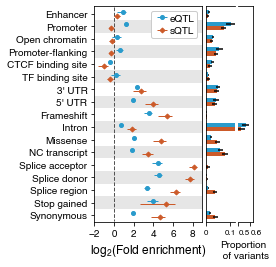

In [7]:
eargs = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':False, 'c':style.qtl_color_s['eqtl'], 'label':'eQTL'}
sargs = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':False, 'c':style.qtl_color_s['sqtl'], 'label':'sQTL'}
plot_enrichment(eqtl_tissue_avg_df, sqtl_tissue_avg_df, mean_df, std_df, eargs, sargs)
plt.savefig('pdfs/Fig4A_torus_enrichment_summary.pdf')

### Panel B: *trans*-eQTLs

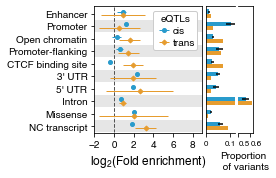

In [8]:
trans_df = pd.read_csv('data/GTEx_Analysis_v8_trans_eGenes_fdr05.txt', sep='\t')
torus_trans_df = qtl.torus.load('data/GTEx_Analysis_v8_eQTL.trans.torus_enrichment.txt', log2=True, short_labels=True)

# drop categories with insufficient overlap
drop_ix = [
    'TF binding site',
    'Frameshift',
    'Splice acceptor',
    'Splice donor',
    'Splice region',
    'Stop gained',
    'Synonymous',
]
# proportion of variants
counts_s = variant_set_s.apply(lambda x: len([i for i in trans_df['variant_id'] if i in x]))
counts_s.rename(index=qtl.torus.torus_short_dict, inplace=True)
counts_s.drop(drop_ix, inplace=True)
pct_s = counts_s/counts_s.sum()
pct_s.name = 'trans'

cargs = {'fmt':'.', 'ms':8,   'lw':1, 'clip_on':True, 'c':style.qtl_color_s['eqtl'], 'label':'cis'}
targs = {'fmt':'D', 'ms':3.5, 'lw':1, 'clip_on':True, 'c':style.qtl_color_s['eqtl_trans'], 'label':'trans'}
plot_enrichment(eqtl_tissue_avg_df.drop(drop_ix), torus_trans_df.drop(drop_ix),
                mean_df[['eQTL']].join(pct_s.to_frame(), how='right'),
                std_df[['eQTL']].join((pct_s*0).to_frame(), how='right'), cargs, targs, legend_title='eQTLs')
plt.savefig('pdfs/Fig4B_torus_enrichment_trans.pdf')

### Panel C: *cis* enrichment of *trans*-eVariants

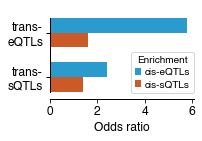

In [9]:
or_df = pd.DataFrame([[5.8, 1.6], [2.4, 1.4]], 
                     columns=['cis-eQTLs', 'cis-sQTLs'],
                     index=['trans-\neQTLs', 'trans-\nsQTLs'])
ax = qtl.plot.setup_figure(2, 1.33, yspace=[0.5,0.25], xspace=[1.25,0.25])
w = 0.66
or_df.plot(kind='barh', ax=ax, width=w, color=[style.qtl_color_s['eqtl'], style.qtl_color_s['sqtl']])
ax.legend(loc='lower right', title='Enrichment', handlelength=0.66, labelspacing=0.33, 
          handletextpad=0.33, borderaxespad=0, bbox_to_anchor=(1,0.1))
ax.set_xlabel('Odds ratio', fontsize=12)
qtl.plot.format_plot(ax, fontsize=12)
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_position(('outward', -4))
ax.invert_yaxis()
plt.savefig('pdfs/Fig4C_trans_cis_enrichment.pdf')

### Panel D: proportion of *trans*-eVariants that are mediated by *cis*-eQTLs

In [10]:
def plot_summary(summary_df, phenotype):
    test_color_s = pd.Series(OrderedDict([
        ('top_evariant', hsv_to_rgb([0, 0, 0.4      ])),
        ('caveman',        hsv_to_rgb([0.5, 0.8, 0.7  ])),
        ('caviar',      hsv_to_rgb([0.025, 0.8, 0.8])),
        ('dap-g' ,      hsv_to_rgb([0.1, 0.8, 0.9  ])),
        ('consensus',    hsv_to_rgb([0.3, 0.99, 0.7 ])),
    ]))

    dl = 0.75
    aw = 0.3*summary_df.shape[0]
    dr = 1.5
    db = 1
    ah = 2
    dt = 0.5
    fw = dl+aw+dr
    fh = db+ah+dt

    fig = plt.figure(facecolor=(1,1,1), figsize=(fw,fh))
    ax = fig.add_axes([dl/fw, db/fh, aw/fw, ah/fh])
    ax.margins(0.03,0)

    colors = [style.qtl_color_s['eqtl'], style.qtl_color_s['eqtl_dark'], [0.75]*3, 
                         [0.5]*3,  test_color_s['consensus']]

    x_pos = np.arange(summary_df.shape[0]).astype(np.float32)
    x_pos[-1] += 0.5
    cols = summary_df.columns[:-2]
    k = 0
    ax.bar(x_pos, summary_df[cols[k]], color=colors[k], label=cols[k], width=0.8)
    for k in range(1,4):
        ax.bar(x_pos, summary_df[cols[k]], bottom=summary_df[cols[:k]].sum(1), color=colors[k], label=cols[k], width=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(summary_df.index, rotation=-45, ha='left')

    x = np.arange(summary_df.shape[0]-2)
    ylim = ax.get_ylim()
    d = ylim[1]-ylim[0]
    s = 1.08
    b = ylim[1] - s*d
    ax.set_ylim(ylim)
    
    colors_df = style.colors_df.append(pd.DataFrame({'color_hex':'#FFFFFF', 'tissue_abbrv':'All tissues (mean)'},
                                                    index=['All tissues (mean)']), sort=False)
    
    ax.scatter(x, b*np.ones(len(x)), s=summary_df['sample_size'].iloc[:-2]/5, 
               c=colors_df.set_index('tissue_abbrv').loc[summary_df.index[:-2], 'color_hex'], clip_on=False)
    for i,n in enumerate(summary_df['trans_genes'].iloc[:-2].astype(int)):
        ax.text(i,1.02,n, ha='center', fontsize=12)
    ax.set_title(phenotype, pad=18, fontsize=14)

    qtl.plot.format_plot(ax, fontsize=12)
    ax.set_xticklabels(summary_df.index, rotation=-36, ha='left')
    ax.tick_params(axis='x', which='major', pad=15, labelsize=10)

    handles, labels = ax.get_legend_handles_labels()
    leg = ax.legend(handles, labels, loc='center left', ncol=1, labelspacing=0.25, 
               columnspacing=1, handletextpad=0.5, handlelength=.66, framealpha=1, bbox_to_anchor=(0.98,0.5))

    ax.set_xlabel(None)
    ax.set_ylabel('Fraction of '+phenotype, fontsize=14)
    ax.spines['bottom'].set_smart_bounds(True)

In [11]:
# enrichment in cis-eQTLs

# restrict to protein coding or lincRNA genes
gene_set = set([g.id for g in annot.genes if g.type in ['protein_coding', 'lincRNA']])

# load trans-eQTL results (0.05 FDR)
trans_df = pd.read_csv('data/GTEx_Analysis_v8_trans_eGenes_fdr05.txt', sep='\t')
for c in ['tested_cis_eqtl', 'tested_cis_sqtl', 'cis_eQTL', 'cis_sQTL']:
    trans_df[c] = False

for tissue_id, gdf in trans_df.groupby('tissue_id'):
    print('\rProcessing {}'.format(tissue_id), end='')
    bed_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL_expression_matrices/{}.v8.normalized_expression.bed.gz'.format(tissue_id),
                    sep='\t', usecols=['#chr', 'end', 'gene_id'], index_col=2).rename(columns={'end':'tss'})
    bed_df['biotype'] = bed_df.index.map(lambda x: annot.gene_dict[x].type)
    bed_df = bed_df[bed_df['biotype'].isin(['protein_coding', 'lincRNA'])]

    group_s = pd.read_csv('data/GTEx_Analysis_v8_sQTL_groups/{}.leafcutter.phenotype_groups.txt'.format(tissue_id),
                          sep='\t', index_col=0, header=None, squeeze=True)
    sqtl_gene_ids = group_s.unique()
    
    signif_eqtl_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL/{}.v8.signif_variant_gene_pairs.txt.gz'.format(tissue_id),
                                 sep='\t', usecols=['variant_id', 'gene_id'])
    signif_eqtl_df = signif_eqtl_df[signif_eqtl_df['gene_id'].apply(lambda x: x in gene_set)]

    signif_sqtl_df = pd.read_csv('data/GTEx_Analysis_v8_sQTL/{}.v8.sqtl_signifpairs.txt.gz'.format(tissue_id),
                                 sep='\t', usecols=['variant_id', 'phenotype_id'])
    signif_sqtl_df['gene_id'] = signif_sqtl_df['phenotype_id'].apply(lambda x: x.split(':')[-1])
    signif_sqtl_df = signif_sqtl_df[signif_sqtl_df['gene_id'].apply(lambda x: x in gene_set)]
    
    for i,r in gdf.iterrows():
        chrom, pos = r['variant_id'].split('_')[:2]
        pos = int(pos)
        tss_s = bed_df.loc[bed_df['#chr']==chrom, 'tss']
        if (tss_s-pos).abs().min() <= 1000000:
            trans_df.loc[i, 'tested_cis_eqtl'] = True
        tss_s = pd.Series([annot.gene_dict[x].tss for x in sqtl_gene_ids], index=sqtl_gene_ids)
        if (tss_s.loc[sqtl_gene_ids]-pos).abs().min() <= 1000000:
            trans_df.loc[i, 'tested_cis_sqtl'] = True
        if r['variant_id'] in signif_eqtl_df['variant_id'].values:
            trans_df.loc[i, 'cis_eQTL'] = True
        if r['variant_id'] in signif_sqtl_df['variant_id'].values:
            trans_df.loc[i, 'cis_sQTL'] = True

Processing Whole_Bloodposed_Lower_legpubiction

In [12]:
# summarize by tissue
summary_df = []
for tissue_id, gdf in trans_df.groupby('tissue_id'):
    sum_s = gdf[['tested_cis_eqtl', 'tested_cis_sqtl', 'cis_eQTL', 'cis_sQTL']].sum()
    sum_s['trans_egenes'] = gdf.shape[0]
    sum_s.name = tissue_id
    summary_df.append(sum_s)
summary_df = pd.concat(summary_df, axis=1).T.astype(int).sort_values('tested_cis_eqtl', ascending=False)
summary_df['sample_size'] = size_s.loc[summary_df.index]
summary_df.index = style.colors_df.loc[summary_df.index, 'tissue_abbrv']

# add mediation results: cis-eQTLs
mediation_df = pd.read_excel('/xchip/gtex/francois/manuscripts/gtex_v8/data/GTEx_v8_mediation_filtered.xlsx',
                             sheet_name='GTEx_v8_mediation_consortium_fi')
mediation_df = mediation_df[mediation_df['BH_FDR']<0.05]
med_s = mediation_df[['trans_gene', 'tissue']].drop_duplicates()['tissue'].value_counts()
med_s.index = style.colors_df.loc[med_s.index, 'tissue_abbrv']
med_s.name = 'cis_eqtl_mediator'
summary_df = summary_df.join(med_s, how='left').fillna(0).astype(int)

# add mediation results: cis-sQTLs
mediation_df = pd.read_excel('/xchip/gtex/francois/manuscripts/gtex_v8/data/GTEx_v8_mediation_filtered.xlsx',
                             sheet_name='GTEx_v8_sQTL_mediation_by_trio_')
mediation_df = mediation_df[mediation_df['BH_FDR']<0.05]
med_s = mediation_df[['trans_gene', 'tissue']].drop_duplicates()['tissue'].value_counts()
med_s.index = style.colors_df.loc[med_s.index, 'tissue_abbrv']
med_s.name = 'cis_sqtl_mediator'
summary_df = summary_df.join(med_s, how='left').fillna(0).astype(int)

summary_df = summary_df.sort_values('sample_size')

# add mean across tissues
mean_s = summary_df.mean()
mean_s.name = 'All tissues (mean)'
summary_df = summary_df.append(mean_s)

# summary_df = summary_df[['trans_egenes', 'tested_cis', 'cis_eQTL', 'cis_eqtl_mediator', 'cis_sQTL', 'cis_sqtl_mediator', 'sample_size']]
subset_df = summary_df[summary_df['trans_egenes']>5]
subset_df

,tested_cis_eqtl,tested_cis_sqtl,cis_eQTL,cis_sQTL,trans_egenes,sample_size,cis_eqtl_mediator,cis_sqtl_mediator
tissue_abbrv,,,,,,,,
TESTIS,49.000000,49.0,20.000000,13.000000,49.0,322.000000,10.000000,13.000000
FIBRBLS,9.000000,9.0,6.000000,2.000000,9.0,483.000000,6.000000,1.000000
SKINNS,7.000000,7.0,3.000000,0.000000,7.0,517.000000,2.000000,0.000000
NERVET,8.000000,8.0,5.000000,1.000000,8.0,532.000000,4.000000,1.000000
THYROID,16.000000,16.0,11.000000,2.000000,16.0,574.000000,9.000000,2.000000
SKINS,16.000000,16.0,9.000000,1.000000,16.0,605.000000,7.000000,1.000000
WHLBLD,11.000000,13.0,2.000000,0.000000,13.0,670.000000,2.000000,0.000000
MSCLSK,9.000000,9.0,9.000000,2.000000,9.0,706.000000,8.000000,1.000000
All tissues (mean),5.851852,6.0,2.851852,0.814815,6.0,395.814815,2.074074,0.740741


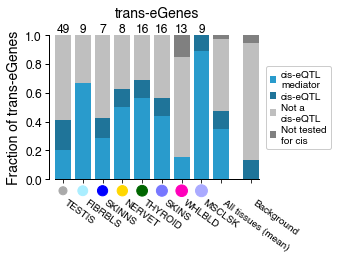

In [13]:
trans_eqtl_frac_df = (pd.concat([
    subset_df['cis_eqtl_mediator'],
    subset_df['cis_eQTL'] - subset_df['cis_eqtl_mediator'] ,
    subset_df['tested_cis_eqtl'] - subset_df['cis_eQTL'],
    subset_df['trans_egenes'] - subset_df['tested_cis_eqtl'],
], axis=1).T / subset_df['trans_egenes']).T
trans_eqtl_frac_df.columns = ['cis-eQTL\nmediator', 'cis-eQTL', 'Not a\ncis-eQTL', 'Not tested\nfor cis']
trans_eqtl_frac_df['sample_size'] = summary_df.loc[trans_eqtl_frac_df.index, 'sample_size']
trans_eqtl_frac_df['trans_genes'] = summary_df['trans_egenes']
# add background
background_df = pd.DataFrame(np.array([[216, 1527-216, 1620-1527]])/1620, 
                             columns=['cis-eQTL', 'Not a\ncis-eQTL', 'Not tested\nfor cis'], 
                             index=['Background'])
trans_eqtl_frac_df = trans_eqtl_frac_df.append(background_df, sort=False).fillna(0)

plot_summary(trans_eqtl_frac_df, phenotype='trans-eGenes')
plt.savefig('pdfs/Fig4D_trans_eqtl_mediation_cis_eqtl.pdf')

### Supplementary figures associated with Fig. 4D

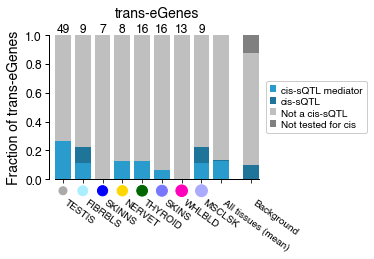

In [14]:
trans_eqtl_sqtl_frac_df = (pd.concat([
    subset_df['cis_sqtl_mediator'],
    subset_df['cis_sQTL'] - subset_df['cis_sqtl_mediator'] ,
    subset_df['tested_cis_sqtl'] - subset_df['cis_sQTL'],
    subset_df['trans_egenes'] - subset_df['tested_cis_sqtl'],
], axis=1).T / subset_df['trans_egenes']).T

trans_eqtl_sqtl_frac_df.columns = ['cis-sQTL mediator', 'cis-sQTL', 'Not a cis-sQTL', 'Not tested for cis']
trans_eqtl_sqtl_frac_df['sample_size'] = summary_df.loc[trans_eqtl_sqtl_frac_df.index, 'sample_size']
trans_eqtl_sqtl_frac_df['trans_genes'] = summary_df['trans_egenes']
# add background
background_df = pd.DataFrame(np.array([[155, 1416-155, 1620-1416]])/1620, 
                             columns=['cis-sQTL', 'Not a cis-sQTL', 'Not tested for cis'], 
                             index=['Background'])
trans_eqtl_sqtl_frac_df = trans_eqtl_sqtl_frac_df.append(background_df, sort=False).fillna(0)
plot_summary(trans_eqtl_sqtl_frac_df, phenotype='trans-eGenes')
plt.savefig('pdfs/Fig4Dsup_trans_eqtl_mediation_cis_sqtl.pdf')

In [15]:
# load trans-sQTL results (0.05 FDR)
trans_sqtl_df = pd.read_csv('data/GTEx_Analysis_v8_trans_sGenes_fdr05.txt', sep='\t')
for c in ['tested_cis_eqtl', 'tested_cis_sqtl', 'cis_eQTL', 'cis_sQTL']:
    trans_sqtl_df[c] = False

for tissue_id, gdf in trans_sqtl_df.groupby('tissue_id'):
    print('\rProcessing {}'.format(tissue_id), end='')
    bed_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL_expression_matrices/{}.v8.normalized_expression.bed.gz'.format(tissue_id),
                    sep='\t', usecols=['#chr', 'end', 'gene_id'], index_col=2).rename(columns={'end':'tss'})
    bed_df['biotype'] = bed_df.index.map(lambda x: annot.gene_dict[x].type)
    bed_df = bed_df[bed_df['biotype'].isin(['protein_coding', 'lincRNA'])]

    group_s = pd.read_csv('data/GTEx_Analysis_v8_sQTL_groups/Whole_Blood.leafcutter.phenotype_groups.txt'.format(tissue_id),
                          sep='\t', index_col=0, header=None, squeeze=True)
    sqtl_gene_ids = group_s.unique()
    
    signif_eqtl_df = pd.read_csv('data/GTEx_Analysis_v8_eQTL/{}.v8.signif_variant_gene_pairs.txt.gz'.format(tissue_id),
                                 sep='\t', usecols=['variant_id', 'gene_id'])
    signif_eqtl_df = signif_eqtl_df[signif_eqtl_df['gene_id'].apply(lambda x: x in gene_set)]

    signif_sqtl_df = pd.read_csv('data/GTEx_Analysis_v8_sQTL/{}.v8.sqtl_signifpairs.txt.gz'.format(tissue_id),
                                 sep='\t', usecols=['variant_id', 'phenotype_id'])
    signif_sqtl_df['gene_id'] = signif_sqtl_df['phenotype_id'].apply(lambda x: x.split(':')[-1])
    signif_sqtl_df = signif_sqtl_df[signif_sqtl_df['gene_id'].apply(lambda x: x in gene_set)]

    for i,r in gdf.iterrows():
        chrom, pos = r['variant_id'].split('_')[:2]
        pos = int(pos)
        tss_s = bed_df.loc[bed_df['#chr']==chrom, 'tss']
        if (tss_s-pos).abs().min() <= 1000000:
            trans_sqtl_df.loc[i, 'tested_cis_eqtl'] = True
        tss_s = pd.Series([annot.gene_dict[x].tss for x in sqtl_gene_ids], index=sqtl_gene_ids)
        if (tss_s.loc[sqtl_gene_ids]-pos).abs().min() <= 1000000:
            trans_sqtl_df.loc[i, 'tested_cis_sqtl'] = True
        if r['variant_id'] in signif_eqtl_df['variant_id'].values:
            trans_sqtl_df.loc[i, 'cis_eQTL'] = True
        if r['variant_id'] in signif_sqtl_df['variant_id'].values:
            trans_sqtl_df.loc[i, 'cis_sQTL'] = True    

Processing Whole_Bloodtine_Terminal_Ileum

In [16]:
# summarize by tissue
trans_sqtl_summary_df = []
for tissue_id, gdf in trans_sqtl_df.groupby('tissue_id'):
    sum_s = gdf[['tested_cis_eqtl', 'tested_cis_sqtl', 'cis_eQTL', 'cis_sQTL']].sum()
    sum_s['trans_sgenes'] = gdf.shape[0]
    sum_s.name = tissue_id
    trans_sqtl_summary_df.append(sum_s)
trans_sqtl_summary_df = pd.concat(trans_sqtl_summary_df, axis=1).T.astype(int).sort_values('tested_cis_eqtl', ascending=False)
trans_sqtl_summary_df['sample_size'] = size_s.loc[trans_sqtl_summary_df.index]
trans_sqtl_summary_df.index = style.colors_df.loc[trans_sqtl_summary_df.index, 'tissue_abbrv']

# add mediation results: cis-eQTLs
mediation_df = pd.read_excel('/xchip/gtex/francois/manuscripts/gtex_v8/data/GTEx_v8_mediation_filtered.xlsx',
                             sheet_name='GTEx_v8_trans_sQTL_mediation_by')
mediation_df = mediation_df[mediation_df['BH_FDR']<0.05]
med_s = mediation_df[['trans_gene', 'tissue']].drop_duplicates()['tissue'].value_counts()
med_s.index = style.colors_df.loc[med_s.index, 'tissue_abbrv']
med_s.name = 'cis_eqtl_mediator'
trans_sqtl_summary_df = trans_sqtl_summary_df.join(med_s, how='left').fillna(0).astype(int)

trans_sqtl_summary_df = trans_sqtl_summary_df.sort_values('sample_size')

# add mean across tissues
mean_s = trans_sqtl_summary_df.mean()
mean_s.name = 'All tissues (mean)'
trans_sqtl_summary_df = trans_sqtl_summary_df.append(mean_s)

subset_df = trans_sqtl_summary_df[trans_sqtl_summary_df['trans_sgenes']>0]

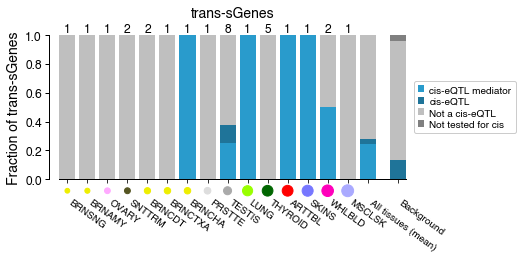

In [17]:
trans_sqtl_frac_df = (pd.concat([
    subset_df['cis_eqtl_mediator'],
    subset_df['cis_eQTL'] - subset_df['cis_eqtl_mediator'] ,
    subset_df['tested_cis_eqtl'] - subset_df['cis_eQTL'],
    subset_df['trans_sgenes'] - subset_df['tested_cis_eqtl'],
], axis=1).T / subset_df['trans_sgenes']).T
trans_sqtl_frac_df.columns = ['cis-eQTL mediator', 'cis-eQTL', 'Not a cis-eQTL', 'Not tested for cis']
trans_sqtl_frac_df['sample_size'] = trans_sqtl_summary_df.loc[trans_sqtl_frac_df.index, 'sample_size']
trans_sqtl_frac_df['trans_genes'] = trans_sqtl_summary_df['trans_sgenes']
# add background
background_df = pd.DataFrame(np.array([[171, 1252-171, 1300-1252]])/1300, 
                             columns=['cis-eQTL', 'Not a cis-eQTL', 'Not tested for cis'], 
                             index=['Background'])
trans_sqtl_frac_df = trans_sqtl_frac_df.append(background_df, sort=False).fillna(0)
plot_summary(trans_sqtl_frac_df, phenotype='trans-sGenes')
plt.savefig('pdfs/Fig4Dsup_trans_sqtl_mediation_cis_eqtl.pdf')